In [118]:
# load dataset

from sklearn import datasets
import numpy as np
import pandas as pd

iris = datasets.load_iris(as_frame=True)
data = iris.data
labels = iris.target
label_names = iris.target_names
name_map = dict(zip(range(3), label_names))
data['label'] = labels.apply(lambda x: name_map[x])

In [119]:
# preprocess data

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(data['label'])
data['class'] = encoder.transform(data['label'])
print(encoder.classes_)
print(data['class'].unique())
data.head()

['setosa' 'versicolor' 'virginica']
[0 1 2]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,class
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


In [120]:
# convert to numpy array for model training

X, y = data.iloc[:, :4].to_numpy(), data.iloc[:, -1].to_numpy()
print(X.shape, y.shape)

(150, 4) (150,)


<AxesSubplot:xlabel='x', ylabel='y'>

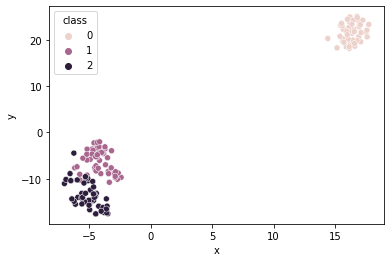

In [121]:
# EDA

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X)
df_plot = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_plot['class'] = data['class']
sns.scatterplot(data=df_plot, x='x', y='y', hue='class')

In [122]:
# data splitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


In [123]:
# normalization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [124]:
# Training model

from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_std, y_train)

SVC(C=1, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



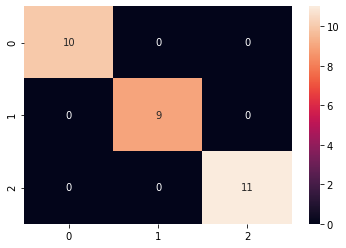

In [125]:
# evaluate results

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = svm.predict(X_test_std)
report = classification_report(y_test, predictions)
print(report)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True)
plt.show()

In [ ]:
X_train_std, X_test_std = X_train_std[:, :2], X_test_std[:, :2]

In [148]:
# convert to numpy array for model training

from sklearn.metrics import accuracy_score

svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_std, y_train)

predictions = svm.predict(X_test_std)
print(accuracy_score(y_test, predictions))

0.8333333333333334


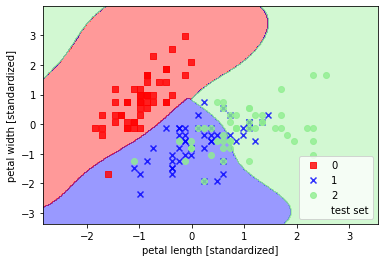

In [149]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
               alpha=0.8, color=cmap(idx),
               marker=markers[idx], label=cl)
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
               alpha=1.0, linewidth=1, marker='o',
               s=55, label='test set')

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std,
                      y_combined, classifier=svm,
                      test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='lower right')
plt.show()


In [156]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'poly', 'rbf'), 'C':[i for i in range(1, 11)], 'gamma': [10e-3, 10e-2, 0.1, 1, 5, 10]}
gs = GridSearchCV(svm, parameters)
gs.fit(X, y)

GridSearchCV(estimator=SVC(C=1, random_state=42),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'gamma': [0.01, 0.1, 0.1, 1, 5, 10],
                         'kernel': ('linear', 'poly', 'rbf')})

In [157]:
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.000806,0.000060,0.000394,0.000064,3,0.1,rbf,"{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}",0.966667,1.000000,1.000000,0.966667,1.000000,0.986667,0.016330,1
44,0.000733,0.000053,0.000317,0.000014,3,0.1,rbf,"{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}",0.966667,1.000000,1.000000,0.966667,1.000000,0.986667,0.016330,1
59,0.000714,0.000078,0.000327,0.000034,4,0.1,rbf,"{'C': 4, 'gamma': 0.1, 'kernel': 'rbf'}",0.966667,1.000000,1.000000,0.966667,1.000000,0.986667,0.016330,1
62,0.000724,0.000040,0.000321,0.000028,4,0.1,rbf,"{'C': 4, 'gamma': 0.1, 'kernel': 'rbf'}",0.966667,1.000000,1.000000,0.966667,1.000000,0.986667,0.016330,1
116,0.000888,0.000226,0.000343,0.000039,7,0.1,rbf,"{'C': 7, 'gamma': 0.1, 'kernel': 'rbf'}",0.966667,1.000000,1.000000,0.966667,1.000000,0.986667,0.016330,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.000713,0.000058,0.000286,0.000047,5,0.01,poly,"{'C': 5, 'gamma': 0.01, 'kernel': 'poly'}",0.933333,0.933333,0.866667,0.933333,0.933333,0.920000,0.026667,176
55,0.000773,0.000082,0.000274,0.000019,4,0.01,poly,"{'C': 4, 'gamma': 0.01, 'kernel': 'poly'}",0.933333,0.933333,0.866667,0.933333,0.900000,0.913333,0.026667,177
37,0.000827,0.000150,0.000276,0.000015,3,0.01,poly,"{'C': 3, 'gamma': 0.01, 'kernel': 'poly'}",0.900000,0.933333,0.900000,0.933333,0.866667,0.906667,0.024944,178
19,0.001371,0.000497,0.000569,0.000181,2,0.01,poly,"{'C': 2, 'gamma': 0.01, 'kernel': 'poly'}",0.833333,0.933333,0.866667,0.933333,0.833333,0.880000,0.045216,179
